In [837]:
import sys
sys.path.append('/mnt/disk01/note/workspaces/duxinxian')
import pandas as pd
import numpy as np
import os
import datetime
import scorecardpy as sc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from unity import feature_selector as fs
from unity.fea_eda_func import FeaEdaFunc

In [2]:
cust_main = pd.read_csv('data/sxd_cust_tag.csv')

In [3]:
cust_main['obs_dt'] = cust_main['obs_dt'].astype(str)

## 1.专家特征处理匹配

In [ ]:
edf = pd.read_excel('data/eprt_fea/sxd_zj.xlsx')

In [704]:
ind = pd.read_excel('data/eprt_fea/东方微银贷后指标.xlsx')

In [705]:
cus_busid = pd.read_csv('data/cust_busid.csv')

In [706]:
cus_busid.head()

,req_id,customerid,businessid
0,12021063017581003436,4500413770,TCL20210600002432
1,12021063017491003435,4500413879,TCL20210600002437
2,12021063016071003421,4500413413,TCL20210600002418
3,12021063013581003370,3000780287,TCL20210600002398
4,12021063017291003433,4500413822,TCL20210600002436


In [675]:
edf.head()

,businessid,WN_BNK001,WN_BNK007,WN_BNK033,WN_BNK043,warn_month,WN_ECR075,WN_ECR011,WN_ECR028,WN_ECR038,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
0,TCL20180900000092,0,0,0,0,2018-10-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCL20180900000092,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCL20180900000145,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCL20180900000145,0,0,0,0,2018-12-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCL20180900000145,0,0,0,0,2019-01-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [676]:
edf['warn_month'] = edf['warn_month'].astype('datetime64[ns]')

In [4]:
cust_main['obj_date'] = pd.to_datetime(cust_main['obs_dt'], format='%Y%m%d')
cust_main['cust_no'] = cust_main['cust_no'].astype(str)
cust_main = cust_main.sort_values(['cust_no','obj_date'])

In [678]:
cus_busid = cus_busid.rename({'customerid':'cust_no'},axis=1)
cus_busid['cust_no'] = cus_busid['cust_no'].astype(str)

In [679]:
edf = cus_busid.merge(edf)
edf = edf.rename({'warn_month':'obj_date'},axis=1)
edf = edf.sort_values(['cust_no','obj_date'])
# edf['obs_dt'] = edf['obj_date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [680]:
edf['p'] = 0
edf.loc[edf['obj_date'] <= '2019-12-31','p'] = 1
edf.loc[(edf['obj_date'] > '2019-12-31')&(edf['obj_date'] <= '2020-03-31'),'p'] = 2
edf.loc[(edf['obj_date'] > '2020-03-31')&(edf['obj_date'] <= '2020-06-30'),'p'] = 3
edf = edf[edf['p'] != 0]

In [681]:
edfp = edf.groupby(['cust_no','p']).last().reset_index()

In [682]:
cust_main['p'] = 0
cust_main.loc[cust_main['obj_date'] == '2019-12-31','p'] = 1
cust_main.loc[cust_main['obj_date'] == '2020-03-31','p'] = 2
cust_main.loc[cust_main['obj_date'] == '2020-06-30','p'] = 3

In [683]:
main_df = cust_main.merge(edfp.loc[:, ~edfp.columns.str.contains('obs_dt|obj_date')],on=['cust_no','p'],how='left')

In [684]:
# TODO:专家特征匹配缺失,cm_retail_lon_acct合同号（cont_no）与进件中的businessid是一个字段

In [685]:
main_df[main_df['businessid'].isnull()]

,cust_no,obs_dt,tag,obj_date,p,req_id,businessid,WN_BNK001,WN_BNK007,WN_BNK033,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
55,3000195780,20191231,0,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,3000195780,20200331,0,2020-03-31,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.行为特征匹配

In [5]:
xw1 = pd.read_csv('data/bhv_fea/sxd_xw_1.csv')
xw2 = pd.read_csv('data/bhv_fea/sxd_xw_2.csv')
xw1.loc[:,['cust_no','obs_dt']] = xw1.loc[:,['cust_no','obs_dt']].astype(str)
xw2.loc[:,['cust_no','obj_date']] = xw2.loc[:,['cust_no','obj_date']].astype(str)

In [6]:
xw2.rename({'obj_date':'obs_dt'},axis=1,inplace=True)

In [8]:
main_df = main_df.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
main_df = main_df.merge(xw2,on=['cust_no','obs_dt'],how = 'left')
# main_df = cust_main.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
# main_df = cust_main.merge(xw2,on=['cust_no','obs_dt'],how = 'left')

In [689]:
# null_cnt = main_df.isnull().sum()/4189
# null_cnt[null_cnt>0.5]

In [9]:
main_df.head()

,cust_no,obs_dt,tag,obj_date,dubil_num_3,dubil_num_6,dubil_num_9,dubil_num_12,count_loan_3,count_loan_6,...,sum_normalpayoff_amt_rate_3,count_ovduepayoff_loan_rate_12,count_ovduepayoff_loan_rate_9,count_ovduepayoff_loan_rate_6,count_ovduepayoff_loan_rate_3,sum_ovduepayoff_amt_rate_12,sum_ovduepayoff_amt_rate_9,sum_ovduepayoff_amt_rate_6,sum_ovduepayoff_amt_rate_3,Unnamed: 106
0,1000000723,20200630,0,2020-06-30,644.0,757.0,757.0,757.0,644.0,757.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1000024521,20191231,0,2019-12-31,93.0,185.0,238.0,238.0,93.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000024521,20200331,0,2020-03-31,92.0,184.0,276.0,329.0,92.0,184.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3000010470,20191231,0,2019-12-31,93.0,185.0,276.0,344.0,93.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000042033,20191231,0,2019-12-31,93.0,100.0,100.0,100.0,93.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.征信特征匹配

In [10]:
zxfea = pd.read_csv('data/zxfea.csv')
zxvar = pd.read_csv('data/zxfea_var.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2087,2088,2089,2090,2091,2093,2094,2095,2096,2097,2098,2100,2101,2102,2103,2104,2105,2106,2109,2110,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
zxvar['var'] = zxvar['var'].str.lower()

In [12]:
zxfea = zxfea.rename({'customer_no':'cust_no'},axis=1).drop(['tag','rn1','id_no','product_code','biz_date'],axis=1)

In [13]:
zxfeas_set = set(zxfea.columns) & set(zxvar['var'])
zxfeas_set = zxfeas_set | {'cust_no','obs_dt'}

In [14]:
zxfea = zxfea[zxfeas_set]
zxfea.loc[:,['cust_no','obs_dt']] = zxfea.loc[:,['cust_no','obs_dt']].astype(str)

In [15]:
main_df = main_df.merge(zxfea,on=['cust_no','obs_dt'])

In [17]:
main_df = main_df.drop(['label_1m','label'],axis=1)

In [18]:
fea_types = main_df.dtypes
fea_types[fea_types == 'object']

cust_no            object
obs_dt             object
zxbiqryorg         object
zxbilhmph          object
zxbilresaddr       object
zxbilempname       object
zxbigdr            object
zxbiedulvl         object
zxbilproftle       object
zxbipermresaddr    object
zxbilposi          object
zxbicontaddr       object
zxbilindus         object
zxbilrescond       object
zxbilempaddr       object
zxbimarst          object
zxbiqryrea         object
zxbiedudeg         object
dtype: object

In [19]:
main_df.to_csv('main_df_drop_zj.csv',index=False)

## 3.特征工程

### 3.1 数据清洗-剔除单一特征与缺失率超过0.7的特征

In [721]:
main_df = pd.read_csv('main_df.csv')
# main_df = pd.read_csv('main_df_drop_zj.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (323,386,387,397,420,425,507,539,556,564,568,576,599,630,637,646) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [722]:
main_df = main_df.replace([-9988,-9989],np.nan)

In [723]:
fsc = fs.FeatureSelector(main_df,labels='tag')

In [724]:
fsc.identify_missing(0.7)
fsc.identify_single_unique()
# fsc.identify_collinear(0.9)

300 features with greater than 0.70 missing values.

121 features with a single unique value.



In [725]:
remove_feas = fsc.check_removal()

Total of 394 features identified for removal


In [726]:
main_df = main_df.drop(remove_feas,axis=1)

In [727]:
train_set = main_df[main_df['obj_date'] != '2020-06-30']
oot_set = main_df[main_df['obj_date'] == '2020-06-30']

In [728]:
train_set['tag'].value_counts()

0    1801
1     200
Name: tag, dtype: int64

In [729]:
oot_set['tag'].value_counts()

0    1312
1     148
Name: tag, dtype: int64

In [730]:
train_set['tag'].value_counts()/len(train_set)

0    0.90005
1    0.09995
Name: tag, dtype: float64

In [731]:
# 包括专家特征
train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)

### 3.2 类别变量处理

In [732]:
from unity.eda_func import EdaFunc

In [733]:
# train_set['dubil_num_3'].astype(float)

In [734]:
fea_types = train_set.dtypes
fea_types[fea_types == 'object']

WN_TAX008    object
area         object
dtype: object

In [735]:
# 包括专家特征
train_set['area'] = train_set['area'].replace({'上海':1,'厦门':2,'福建':3})
oot_set['area'] = oot_set['area'].replace({'上海':1,'厦门':2,'福建':3})

In [736]:
# 包括专家特征
unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
               'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
               'zxgcsste','WN_ICR022', 'WN_ICR040', 'WN_LEG039', 'WN_LEG033', 'warn_state']
train_set = train_set.drop(unique_feas,axis=1)
oot_set = oot_set.drop(unique_feas,axis=1)

In [737]:
train_set.shape

(2001, 248)

In [738]:
oot_set.shape

(1460, 248)

### 3.3 划分样本

In [838]:
tra_x,tst_x,tra_y,tst_y = train_test_split(train_set,train_set['tag'],shuffle=True,test_size=0.3,random_state=2)
oot_x = oot_set.copy()
oot_y = oot_set['tag']

In [839]:
tra_y.value_counts()

0    1253
1     147
Name: tag, dtype: int64

In [840]:
tst_y.value_counts()

0    548
1     53
Name: tag, dtype: int64

* <font size=4 color=red face=仿宋>直接先用树模型筛选特征</font>

In [841]:
# 包括专家特征
cat_feas = ['WN_BNK007','WN_TAX008','tag']
tra_x = tra_x.drop(cat_feas,axis=1)
tst_x = tst_x.drop(cat_feas,axis=1)
oot_x = oot_x.drop(cat_feas,axis=1)
# 不包括专家特征
# cat_feas = ['tag']
# tra_x = tra_x.drop(cat_feas,axis=1)
# tst_x = tst_x.drop(cat_feas,axis=1)
# oot_x = oot_x.drop(cat_feas,axis=1)

In [842]:
# tra_x = tra_x.apply(lambda x:x.fillna(x.median()))
# tst_x = tst_x.apply(lambda x:x.fillna(x.median()))
# oot_x = oot_x.apply(lambda x:x.fillna(x.median()))

tra_x = tra_x.apply(lambda x:x.replace({np.inf:np.nan}))
tst_x = tst_x.apply(lambda x:x.replace({np.inf:np.nan}))
oot_x = oot_x.apply(lambda x:x.replace({np.inf:np.nan}))

In [843]:
np.where(tra_x == np.inf)

(array([], dtype=int64), array([], dtype=int64))

#### 交叉验证筛选特征

In [844]:
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=2)

In [847]:
# sele = set()
# n = 1
# for tra_index,tst_index in skf.split(tra_x,tra_y):
#     print(f'第{n}折')
#     ktrax = tra_x.iloc[tra_index,:]
#     ktray = tra_y.iloc[tra_index]
#     ktstx = tra_x.iloc[tst_index,:]
#     ktxty = tra_y.iloc[tst_index]
#     clf = RandomForestClassifier(random_state=2)
#     clf.fit(ktrax,ktray)
#     imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
#     sele = sele | set(imp['importance'].head(50).index)
#     n+=1

In [848]:
# tra_x = tra_x.drop('tag',axis=1)
# tst_x = tst_x.drop('tag',axis=1)
clf = LGBMClassifier(random_state=2,class_weight='balanced')
clf.fit(tra_x,tra_y)
tra_pred_y = clf.predict_proba(tra_x)[:,1]
imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
sele = set(imp['importance'].head(50).index)

In [849]:
tra_x = tra_x[sele]
tst_x = tst_x[sele]
oot_x = oot_x[sele]

In [850]:
# tra_x = tra_x.drop(hcorr_lis,axis=1)
# tst_x = tst_x.drop(hcorr_lis,axis=1)
# oot_x = oot_x.drop(hcorr_lis,axis=1)

In [851]:
# clf.fit(tra_x,tra_y)
# tra_pred_y = clf.predict_proba(tra_x)[:,1]
# tst_pred_y = clf.predict_proba(tst_x)[:,1]
# oot_pred_y = clf.predict_proba(oot_x)[:,1]

In [852]:
# sc.perf_eva(tra_y,tra_pred_y)   

In [853]:
# sc.perf_eva(tst_y,tst_pred_y)   

In [854]:
# sc.perf_eva(oot_y,oot_pred_y)    

### 3.3 决策树分箱

In [855]:
tra_x = pd.concat([tra_x,tra_y],axis=1)
tst_x = pd.concat([tst_x,tst_y],axis=1)
oot_x = pd.concat([oot_x,oot_y],axis=1)

In [856]:
bins_dic  =sc.woebin(tra_x,y='tag',method='chimerge')

[INFO] creating woe binning ...


### 3.4 调整分箱

In [857]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
WN_ICR043,False,0.509032
WN_ICR120,False,0.450696
WN_TAX017,False,0.412969
WN_TAX019,False,0.400064
WN_TAX025,False,0.378154
WN_TAX024,False,0.327499
zxysavgloanbalanceamt,False,0.295184
WN_TAX027,False,0.282817
WN_TAX011,False,0.223751


In [858]:
# sc.woebin_plot(bins_dic,x=fea_info[fea_info['iv'] > 0.05].index.to_list())

In [859]:
adj_bin = sc.woebin(tra_x,x=['zxage','zxysavgloanbalanceamt','zxcrdpctrmbcurccpr','zxnmlccusedamt'],y='tag',
                    breaks_list={'zxage':[35,46],'zxysavgloanbalanceamt':[80000,220000,680000],'zxcrdpctrmbcurccpr':[15,25,80],
                                'zxnmlccusedamt':[80000,150000,450000,750000]},
                   )

[INFO] creating woe binning ...


{'zxysavgloanbalanceamt': <Figure size 432x288 with 2 Axes>,
 'zxage': <Figure size 432x288 with 2 Axes>,
 'zxcrdpctrmbcurccpr': <Figure size 432x288 with 2 Axes>,
 'zxnmlccusedamt': <Figure size 432x288 with 2 Axes>}

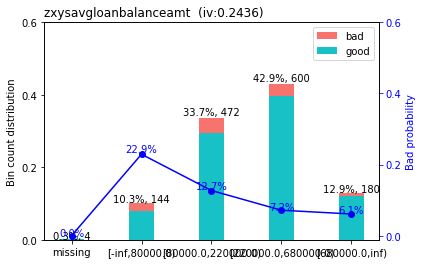

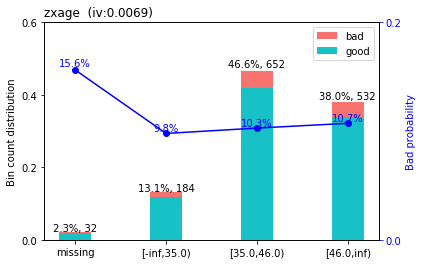

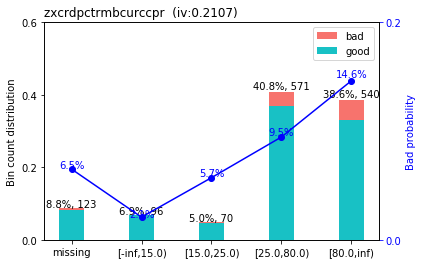

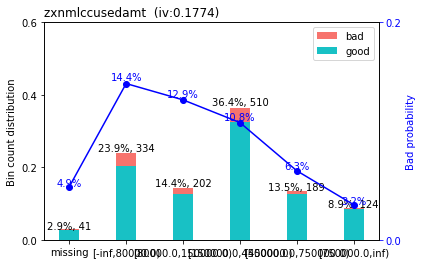

In [860]:
sc.woebin_plot(adj_bin,x=['zxysavgloanbalanceamt','zxage','zxcrdpctrmbcurccpr','zxnmlccusedamt'])

In [861]:
bins_dic.update(adj_bin)

### 3.5 剔除iv<0.05的特征

In [862]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
WN_ICR043,False,0.509032
WN_ICR120,False,0.450696
WN_TAX017,False,0.412969
WN_TAX019,False,0.400064
WN_TAX025,False,0.378154
WN_TAX024,False,0.327499
WN_TAX027,False,0.282817
zxysavgloanbalanceamt,False,0.243607
WN_TAX011,False,0.223751


In [863]:
ivdrop_feas = fea_info[fea_info['iv'] < 0.02].index.to_list()

In [864]:
bins_drop_dic = [bins_dic.pop(k) for k in ivdrop_feas]

In [865]:
tra_x = tra_x.drop(ivdrop_feas,axis=1)
tst_x = tst_x.drop(ivdrop_feas,axis=1)
oot_x = oot_x.drop(ivdrop_feas,axis=1)

### 3.5 woe

In [866]:
tra_x_woe = sc.woebin_ply(tra_x,bins_dic)
tst_x_woe = sc.woebin_ply(tst_x,bins_dic)
oot_x_woe = sc.woebin_ply(oot_x,bins_dic)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


### 3.6 剔除psi大于0.1的特征

In [867]:
# tst_bin_group = FeaEdaFunc.bin_group(tst_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')
# oot_bin_group = FeaEdaFunc.bin_group(oot_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')

In [868]:
def calc_psi(bindic,exp,act):
    psi_dic = {}
    con_dic = {}
    for k,b in bindic.items():
        g1 = exp[[k]].fillna('missing')
        g2 = act[[k]].fillna('missing')
        cut_bin = b.loc[b['breaks']!= 'missing','breaks'].astype(float)
        cut_bin.loc[len(cut_bin)+1] = '-inf'
        cut_bin = cut_bin.astype(float).sort_values()
        g1['c'] = pd.cut(g1.loc[g1[k] != 'missing',k],bins=cut_bin,right=False)
        g2['c'] = pd.cut(g2.loc[g2[k] != 'missing',k],bins=cut_bin,right=False)
        g1['c'] = g1['c'].astype(str)
        g1.loc[g1[k] == 'missing','c'] = 'missing'
        count_a = g1.groupby('c').size()/len(g1)
        g2['c'] = g2['c'].astype(str)
        g2.loc[g2[k] == 'missing','c'] = 'missing'
        count_e = g2.groupby('c').size()/len(g2)
        con = pd.concat([count_a,count_e],axis=1,keys=['a','e'])
        con['a-e'] = con['a'] - con['e']
        con['ln(a/e)'] = np.log(con['a']/con['e'])
        con_dic[k] = con
        x = (con['a'] - con['e'])*np.log(con['a']/con['e'])
        x = x[~x.isnull()]
        psi = sum(x)
        psi_dic[k] = psi
    return psi_dic,con_dic

In [869]:
psi_info1,con_info1 = calc_psi(bins_dic,tra_x,tst_x)
psi_info2,con_info2 = calc_psi(bins_dic,tra_x,oot_x)
psi_info3,con_info3 = calc_psi(bins_dic,tst_x,oot_x)

/home/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [870]:
psi_df1 = pd.DataFrame(psi_info1,index=['psi']).T.sort_values('psi',ascending=False)
psi_df2 = pd.DataFrame(psi_info2,index=['psi']).T.sort_values('psi',ascending=False)
psi_df3 = pd.DataFrame(psi_info3,index=['psi']).T.sort_values('psi',ascending=False)

In [871]:
psi_drop1 = set(psi_df1[psi_df1['psi']>0.2].index)
psi_drop2 = set(psi_df2[psi_df2['psi']>0.2].index)
psi_drop3 = set(psi_df3[psi_df3['psi']>0.2].index)
psi_drop = psi_drop1 | psi_drop2 | psi_drop3

In [872]:
psi_drop = [i+'_woe' for i in psi_drop]

In [873]:
fea_info.reindex([i.split('_woe')[0] for i in tra_x_woe.columns[1:]])

,mono_status,iv
variable,,
zxutlpctallcuraccpr,True,0.134860
zxcrecardusecreditrate,True,0.053972
WN_MIX018,False,0.054015
rh_tot_used_limit_rate,True,0.075436
WN_MIX017,False,0.154470
zxpayamtavgstrmbcurallpr,False,0.029142
WN_MIX023,False,0.050955
WN_TAX036,False,0.159718
WN_TAX019,False,0.400064


### 3.7 共线性剔除 

In [828]:
# tra_x_woe.corr().style.background_gradient()

In [874]:
tst_x_woe = tst_x_woe.drop(psi_drop,axis=1)
tra_x_woe = tra_x_woe.drop(psi_drop,axis=1)
oot_x_woe = oot_x_woe.drop(psi_drop,axis=1)

In [875]:
tra_x_woe = tra_x_woe.drop('tag',axis=1).reset_index(drop=True)
tst_x_woe = tst_x_woe.drop('tag',axis=1).reset_index(drop=True)
oot_y = oot_x_woe['tag'].reset_index(drop=True)
oot_x_woe = oot_x_woe.drop('tag',axis=1).reset_index(drop=True)

### 3.8 初步测试

In [699]:
# def val_clf(x,y,oot_x,oot_y,score,clf=LGBMClassifier(),pert_func=sc.perf_eva):
#     tra_x,tst_x,tra_y,tst_y = train_test_split(x,y,test_size=0.3,shuffle=True)
#     clf.fit(tra_x,tra_y)
#     pred_y = clf.predict_proba(tst_x)[:,1]
#     oot_pred_y = clf.predict_proba(oot_x)[:,1]
#     if pert_func:
#         pert_func(tst_y,pred_y)
#         pert_func(oot_y,oot_pred_y)
#     else:
#         print(score(tst_y,pred_y))

In [876]:
tst_x_woe = tst_x_woe.apply(lambda x:x.fillna(x.median()))
oot_x_woe = oot_x_woe.apply(lambda x:x.fillna(x.median()))

In [877]:
tra_x_woe.shape

(1400, 44)

In [901]:
n = 8
# clf = LogisticRegression(class_weight='balanced')
# clf = RandomForestClassifier(class_weight='balanced')
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(tra_x_woe.iloc[:,:n],tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe.iloc[:,:n])[:,1]
tst_pred_y = clf.predict_proba(tst_x_woe.iloc[:,:n])[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe.iloc[:,:n])[:,1]

In [917]:
clf.feature_importances_

array([0.24551389, 0.02349804, 0.0784633 , 0.03483567, 0.22001063,
       0.12159492, 0.07826902, 0.19781455])

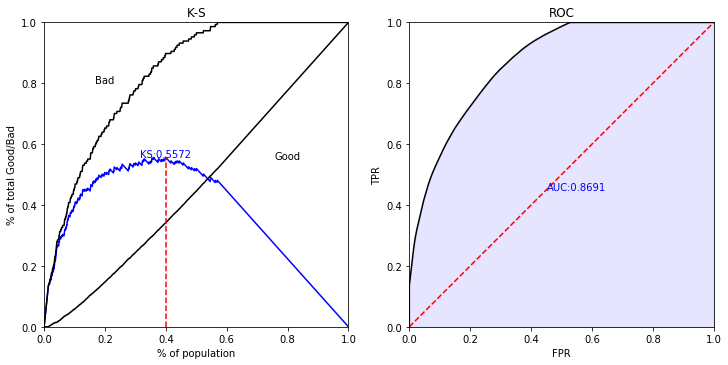

{'KS': 0.5572,
 'AUC': 0.8691,
 'Gini': 0.7382,
 'pic': <Figure size 864x432 with 2 Axes>}

In [902]:
sc.perf_eva(tra_y,tra_pred_y)  

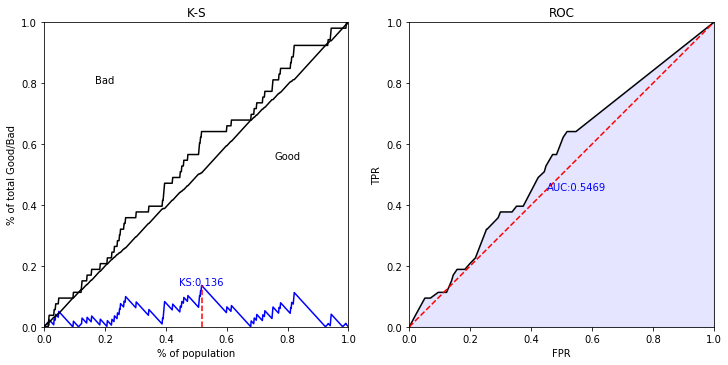

{'KS': 0.136,
 'AUC': 0.5469,
 'Gini': 0.0938,
 'pic': <Figure size 864x432 with 2 Axes>}

In [903]:
sc.perf_eva(tst_y,tst_pred_y)                                                                                                                                   

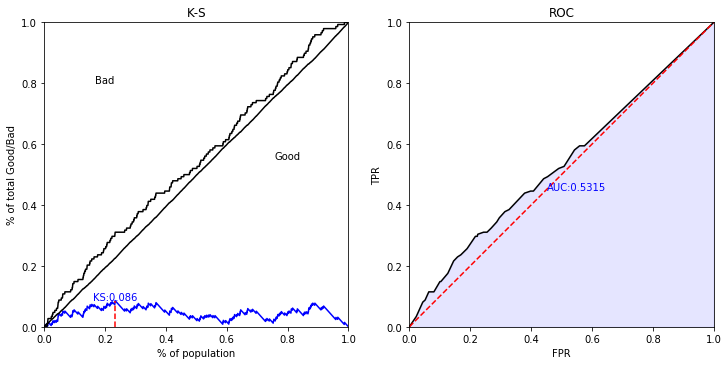

{'KS': 0.086,
 'AUC': 0.5315,
 'Gini': 0.063,
 'pic': <Figure size 864x432 with 2 Axes>}

In [904]:
sc.perf_eva(oot_y,oot_pred_y)  

In [707]:
# error_drop_feas = ['WN_TAX015_woe','zxutlpctrmbcurccpr_woe','WN_TAX027_woe','zxhomeaddrcnt_woe','WN_ICR002_woe','WN_MIX025_woe',
# 'zxracplpr_woe']
# error_drop_feas = ['zxracplpr_woe']
# tra_x_woe.drop(error_drop_feas,axis=1,inplace=True)
# tst_x_woe.drop(error_drop_feas,axis=1,inplace=True)
# oot_x_woe.drop(error_drop_feas,axis=1,inplace=True)

### 3.9 逐步回归

In [784]:
step_drop_feas,step_res = FeaEdaFunc.step_logit(tra_x_woe,tra_y)

Optimization terminated successfully.
         Current function value: 0.335932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329298
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.020     
Dependent Variable:      y                   AIC:                 932.0331  
Date:                    2021-09-13 15:26    BIC:                 958.2543  
No. Observations:        1400                Log-Likelihood:      -461.02   
Df Model:                4        

In [785]:
tra_x_woe.drop(step_drop_feas,axis=1,inplace=True)
tst_x_woe.drop(step_drop_feas,axis=1,inplace=True)
oot_x_woe.drop(step_drop_feas,axis=1,inplace=True)

In [786]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
tst_pred_y = clf.predict_proba(tst_x_woe)[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe)[:,1]

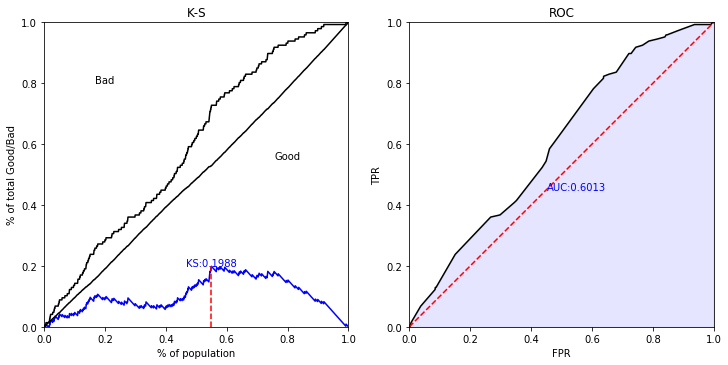

{'KS': 0.1988,
 'AUC': 0.6013,
 'Gini': 0.2026,
 'pic': <Figure size 864x432 with 2 Axes>}

In [787]:
sc.perf_eva(tra_y,tra_pred_y)  

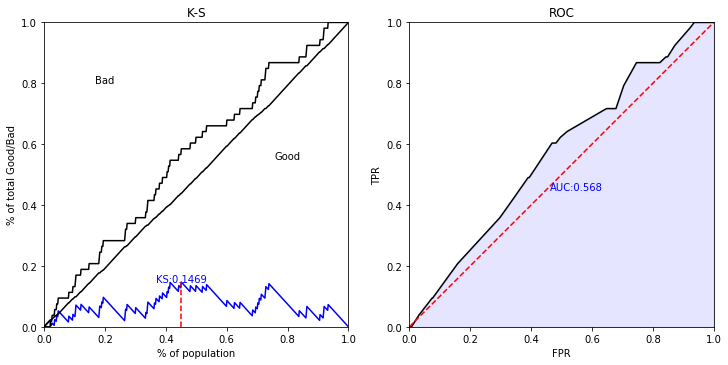

{'KS': 0.1469,
 'AUC': 0.568,
 'Gini': 0.136,
 'pic': <Figure size 864x432 with 2 Axes>}

In [788]:
sc.perf_eva(tst_y,tst_pred_y)

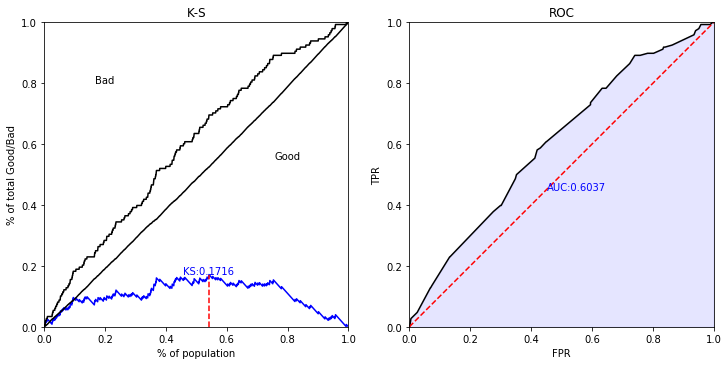

{'KS': 0.1716,
 'AUC': 0.6037,
 'Gini': 0.2073,
 'pic': <Figure size 864x432 with 2 Axes>}

In [789]:
sc.perf_eva(oot_y,oot_pred_y) 